# Load required libraries and Data File

In [1]:
import math
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.stats import zscore
import statsmodels.api as sm
from scipy import stats
from sklearn import metrics
from sklearn import datasets
#from imblearn.over_sampling import SMOTE
# from sklearn.cross_validation import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('seaborn-whitegrid')

In [2]:
df = pd.read_csv('Bank_Personal_Loan_Modelling.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
ID                    5000 non-null int64
Age                   5000 non-null int64
Experience            5000 non-null int64
Income                5000 non-null int64
ZIP Code              5000 non-null int64
Family                5000 non-null int64
CCAvg                 5000 non-null float64
Education             5000 non-null int64
Mortgage              5000 non-null int64
Personal Loan         5000 non-null int64
Securities Account    5000 non-null int64
CD Account            5000 non-null int64
Online                5000 non-null int64
CreditCard            5000 non-null int64
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


Findings: None of the column has any null or missing value

# Exploratory Data Analysis

In [3]:
print("dimension of Banking data: {}".format(df.shape))

dimension of Banking data: (5000, 14)


In [4]:
print(df.groupby('Personal Loan').size())

Personal Loan
0    4520
1     480
dtype: int64


Findings: Data is biased towards customers who didn't accepted the personal loan in earlier campaigns

In [5]:
 # Let us check whether any of the columns has any value other than numeric i.e. data is not corrupted such as a "?" 
    # instead of a number.
df[~df.applymap(np.isreal).all(1)]

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard


Findings: data is not corrupted such as a "?" instead of a number.

In [6]:
# Check if any data value across all columns is NULL or not
df.isnull().values.any()

False

In [7]:
print(df.isnull().sum())

ID                    0
Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64


NO Missing values in data

In [8]:
# Get real feel of data by looking at it
# Entire Independent variables are split across continuous,discrete & boolean variables 
df.head(5)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E56C583DD8>,
      dtype=object)

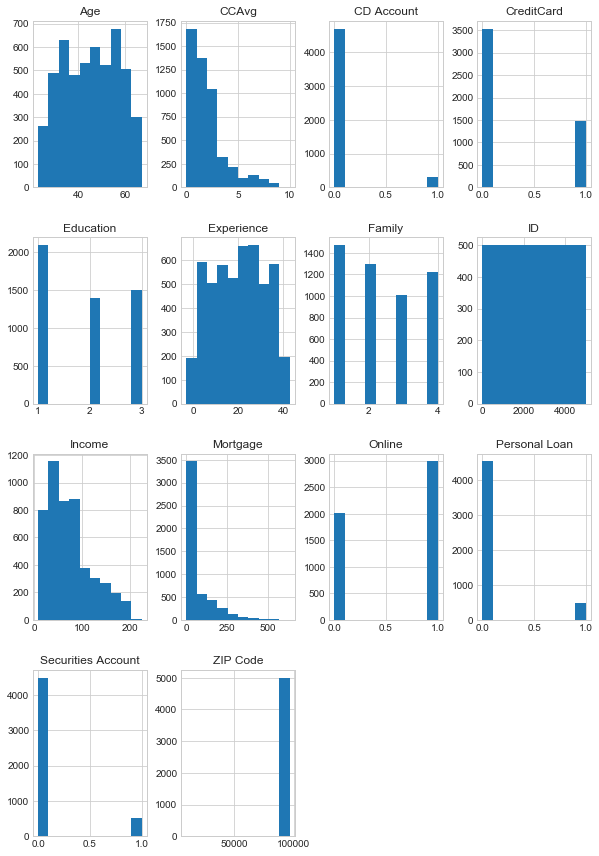

In [9]:
df.hist(figsize=(10,15))

Findings: #1) Age, Experience and Income has multiple peaks which means data is taken from different populations
#2)  Majority of people are undergraduates and availing online banking facility
#3) Average CC Spending is pretty high for a limited number of customers 
#4) Majority of customers have not availed products of bank such as Securities Account, Personal Loan,CD Account
#5) Income shows right extended tail which means very minimal customers fall in high income group

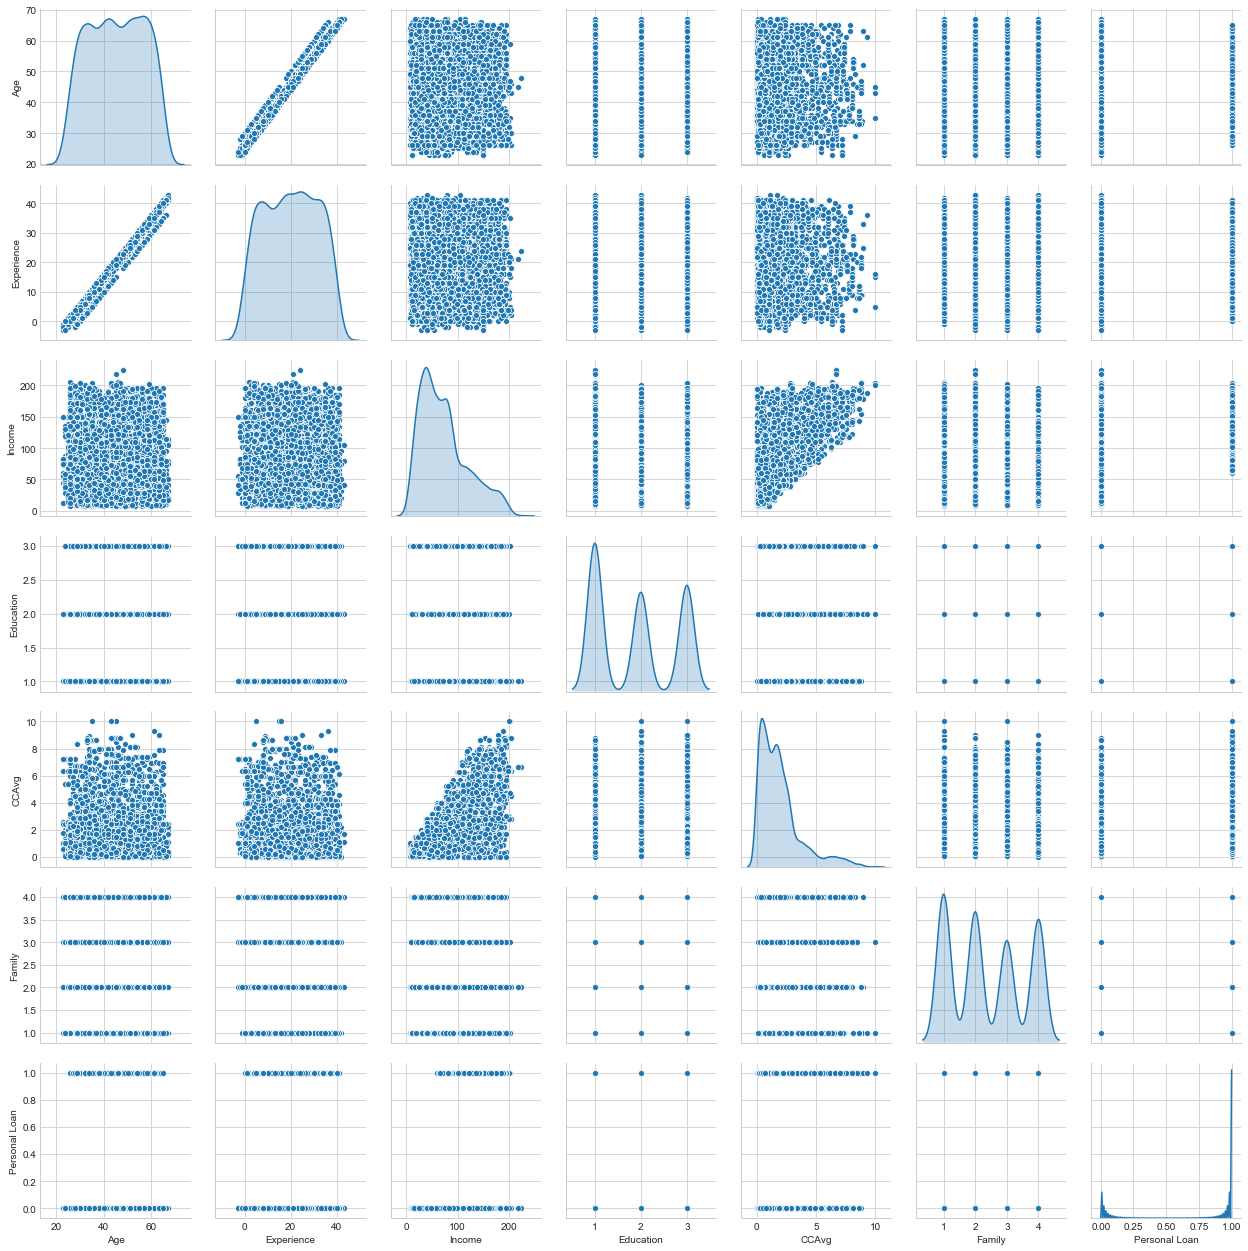

In [10]:
sns.pairplot(df [['Age','Experience','Income','Education','CCAvg','Family','Personal Loan']], diag_kind='kde')

Findings: #1) Age and Experience have linear relationship
#2) CCAvg and Income shows approx linear relationship which means Higher salaried people have relatively more CC spendings
#3) CCAvg and Income have long right tail which means very less people fall in category of high income group. Same hold good for CC Average sending also

# Target Column Distribution

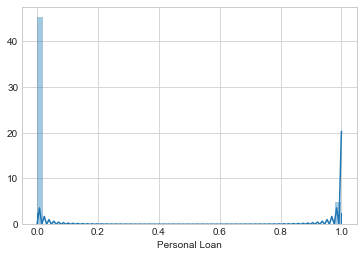

In [11]:
sns.distplot(df['Personal Loan'], rug=True)

Findings: There is phenomenal difference between the people who have opted for personal loan and who have not.
    Very less number of people are the ones who have opted for personal loan in past

# Preparing the data to train the model

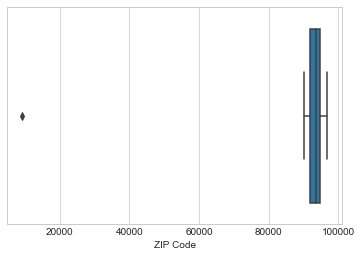

In [12]:
# ZIP Code has outliers which influences data distrobution
sns.boxplot(x=df['ZIP Code'])

In [13]:
# Removing the ZIP Code Outlier which is only 1 data item
df = df.ix[df['ZIP Code'] != 9307]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


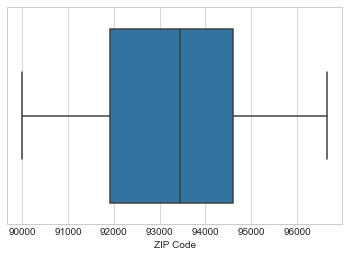

In [14]:
sns.boxplot(x=df['ZIP Code'])

In [15]:
# Shows 1 row of above specified ZIP Code is removed
df.shape

(4999, 14)

In [16]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,4999.0,2500.923185,1443.354188,1.0,1251.5,2501.0,3750.5,5000.0
Age,4999.0,45.337267,11.464033,23.0,35.0,45.0,55.0,67.0
Experience,4999.0,20.103621,11.468892,-3.0,10.0,20.0,30.0,43.0
Income,4999.0,73.784757,46.032281,8.0,39.0,64.0,98.0,224.0
ZIP Code,4999.0,93169.275455,1759.630610,90005.0,91911.0,93437.0,94608.0,96651.0
Family,4999.0,2.396079,1.147554,1.0,1.0,2.0,3.0,4.0
CCAvg,4999.0,1.938206,1.747731,0.0,0.7,1.5,2.5,10.0
Education,4999.0,1.880776,0.839804,1.0,1.0,2.0,3.0,3.0
Mortgage,4999.0,56.510102,101.720837,0.0,0.0,0.0,101.0,635.0
Personal Loan,4999.0,0.096019,0.294647,0.0,0.0,0.0,0.0,1.0


In [17]:
df["Income"] = df["Income"].mask(df["Income"] >205, df['Income'].median())
df["CCAvg"] = df["CCAvg"].mask(df["CCAvg"] >9, df['CCAvg'].median())
df["Mortgage"] = df["Mortgage"].mask(df["Mortgage"] ==0, df['Mortgage'].mean())

Income, CCAvg & Mortgage columns too have outliers and hence needed to be settled as much as possible.

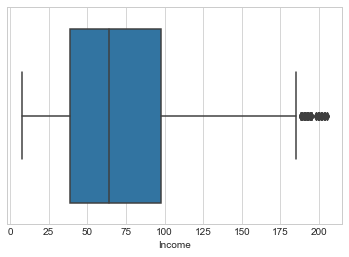

In [18]:
sns.boxplot(x=df['Income'])

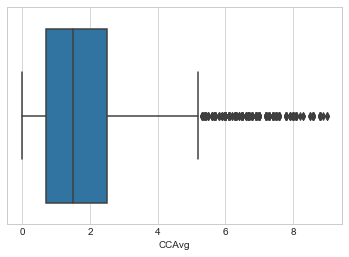

In [19]:
sns.boxplot(x=df['CCAvg'])

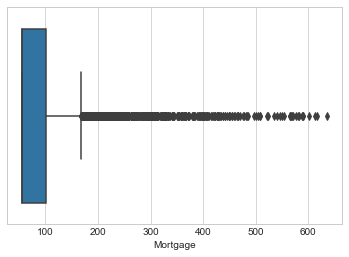

In [20]:
sns.boxplot(x=df['Mortgage'])

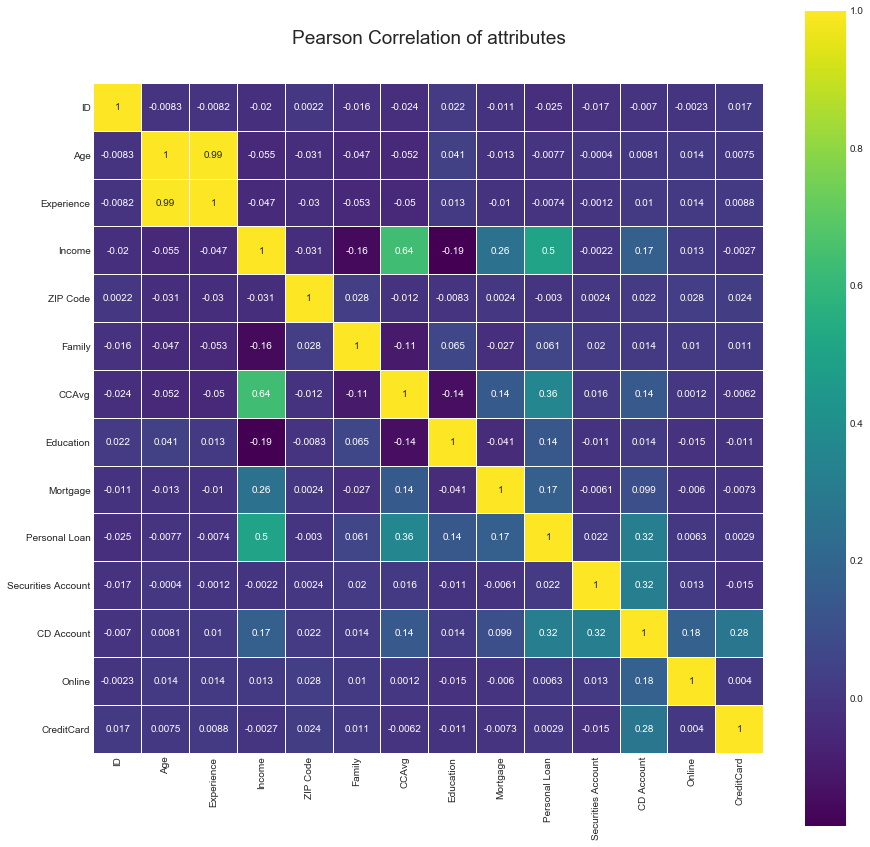

In [21]:
colormap = plt.cm.viridis # Color range to be used in heatmap
plt.figure(figsize=(15,15))
plt.title('Pearson Correlation of attributes', y=1.05, size=19)
sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

Findings : 
#1) Age and Experience show strong correlation hence one of column (may be Experience can be dropped which anyway have no significance in model while opting personal loan).
#2) There is no strong correlation between any independent variable and class (Personal Loan) variable.
#3) Income and CCAvg have moderate correlation
#4) Various attributes have negative correlation

In [22]:
newdf=df.drop(['ID', 'Experience'], axis=1)

In [23]:
newdf.head(5)

,Age,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,49,91107,4,1.6,1,56.510102,0,1,0,0,0
1,45,34,90089,3,1.5,1,56.510102,0,1,0,0,0
2,39,11,94720,1,1.0,1,56.510102,0,0,0,0,0
3,35,100,94112,1,2.7,2,56.510102,0,0,0,0,0
4,35,45,91330,4,1.0,2,56.510102,0,0,0,0,1


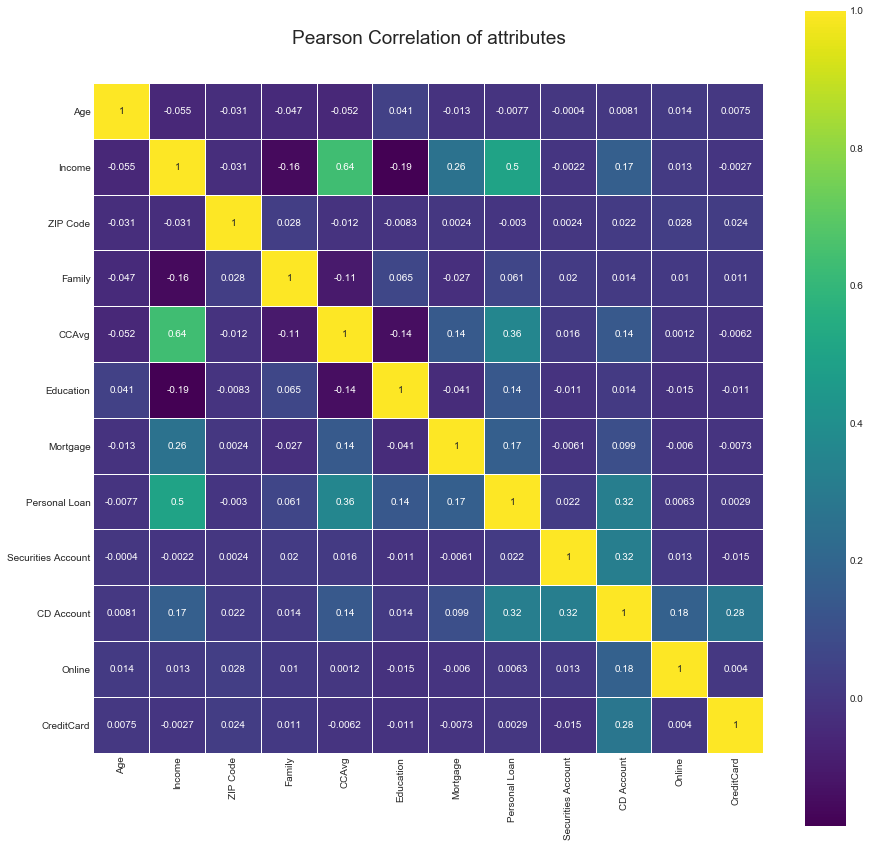

In [24]:
colormap = plt.cm.viridis # Color range to be used in heatmap
plt.figure(figsize=(15,15))
plt.title('Pearson Correlation of attributes', y=1.05, size=19)
sns.heatmap(newdf.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
#ID & Experience columns have been dropped out

Findings: Headmap or Correlation Matrix after removing ID and Experience column

In [25]:
print(newdf.groupby('Personal Loan').size())

Personal Loan
0    4519
1     480
dtype: int64


# Logistics Regression Model

In [28]:
# Feature Selection
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

cols = ["Age","Income","ZIP Code","Family","CCAvg","Education","Mortgage","Securities Account","CD Account","Online","CreditCard"] 
X = newdf[cols]
y = newdf['Personal Loan']

# Build a logreg and compute the feature importances
model = LogisticRegression()

# create the RFE model and select 10 attributes
rfe = RFE(model, 10)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes
#print('Selected features: %s' % list(X_resampled.columns[rfe.support_]))

#X_train, X_test, y_train, y_test = train_test_split(newdf.loc[:, newdf.columns != 'Personal Loan'], newdf['Personal Loan'], test_size=0.3,random_state=42)

#logit = sm.Logit( y_train, sm.add_constant( X_train ) )
#lg = logit.fit()
#lg.summary2()


C:\Users\VK186001\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\VK186001\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [30]:
from sklearn.feature_selection import RFECV
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(), step=1, min_features_to_select=10,cv=2, scoring='accuracy')
rfecv.fit(X, y)

C:\Users\VK186001\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\VK186001\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\VK186001\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\VK186001\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\VK186001\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logisti

RFECV(cv=2,
      estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=100,
                                   multi_class='warn', n_jobs=None,
                                   penalty='l2', random_state=None,
                                   solver='warn', tol=0.0001, verbose=0,
                                   warm_start=False),
      min_features_to_select=10, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [31]:
Selected_features = ['Age', 'Income', 'ZIP Code', 'Family', 'CCAvg', 'Education', 'Mortgage', 'Securities Account', 'CD Account', 'Online', 'CreditCard']
X = newdf[Selected_features]

In [33]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
# create X (features) and y (response)
X = newdf[Selected_features]
y = newdf['Personal Loan']
# use train/test split with different random_state values
# we can change the random_state values that changes the accuracy scores
# the scores change a lot, this is why testing scores is a high-variance estimate
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=2)
# check classification scores of logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(Y_test, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(Y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(Y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

Train/Test split results:
LogisticRegression accuracy is 0.922
LogisticRegression log_loss is 0.180
LogisticRegression auc is 0.921
Using a threshold of 0.070 guarantees a sensitivity of 0.962 and a specificity of 0.799, i.e. a false positive rate of 20.07%.


C:\Users\VK186001\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [34]:
cm = confusion_matrix(Y_test, y_pred)
cm

array([[902,  20],
       [ 58,  20]], dtype=int64)

In [35]:
# evaluate accuracy & Recall
print(accuracy_score(Y_test, y_pred))
print(recall_score(Y_test, y_pred))

0.922
0.2564102564102564


Logistics Regression Model gives good accuracy but very low recall

# Naive Bayes Model for Classification

In [37]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
# We only have option to use GaussianNB because MultinomialNB is used for text/document classification 
# Gaussian expects predictors to take up continuous value and assume values are sampled from a gaussian distribution. 
# However we can see that following variables are neither continuous nor they follow normal/gaussian distribution.
 # 

In [ ]:
cols = ["Age","Income","ZIP Code","Family","CCAvg","Education","Mortgage","Securities Account","CD Account","Online","CreditCard"] 
X = newdf[cols]
y = newdf['Personal Loan']

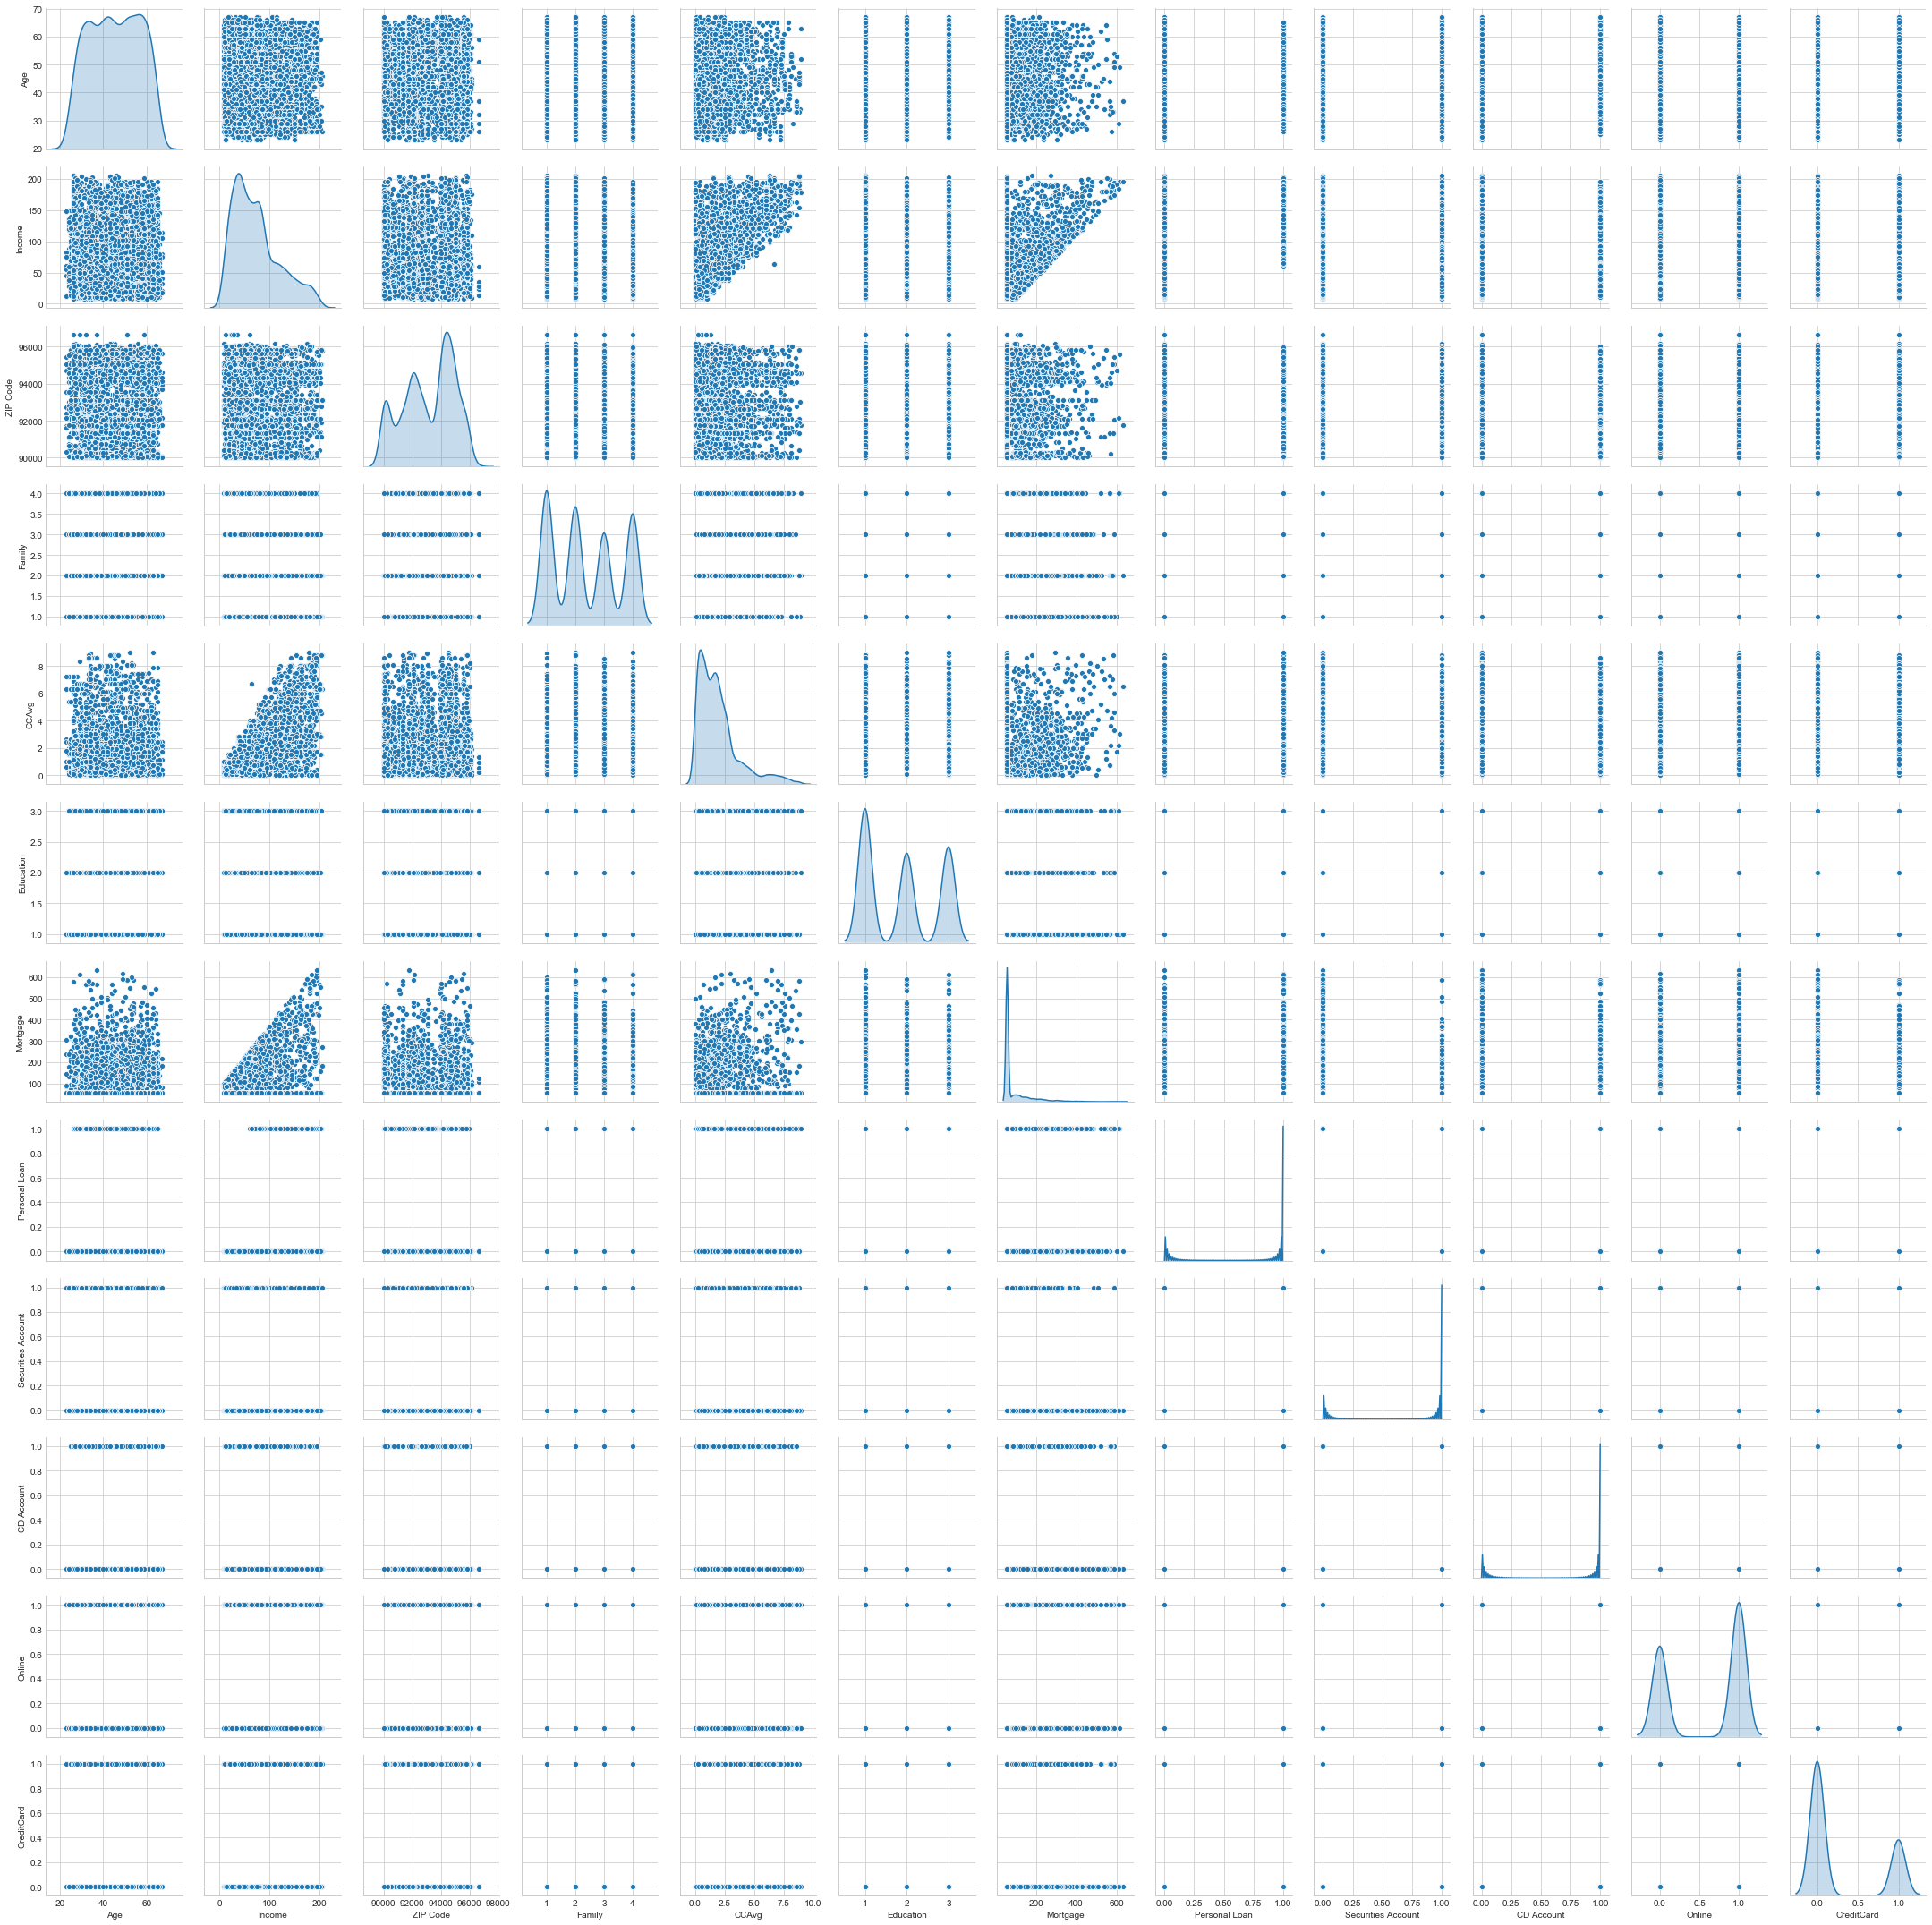

In [38]:
sns.pairplot(newdf,diag_kind='kde')

In [42]:
from sklearn import model_selection
test_size = 0.30 # taking 70:30 training and test set
seed = 7  # Random numbmer seeding for reapeatability of the code
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, y, test_size=test_size, random_state=seed)

In [43]:
model = GaussianNB()
model.fit(X_train, Y_train)
print(model)
# make predictions
expected = Y_test
predicted = model.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

GaussianNB(priors=None, var_smoothing=1e-09)
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      1352
           1       0.42      0.55      0.48       148

    accuracy                           0.88      1500
   macro avg       0.69      0.74      0.71      1500
weighted avg       0.90      0.88      0.89      1500

[[1241  111]
 [  66   82]]


In [41]:
print("Accuracy:",metrics.accuracy_score(expected, predicted))

Accuracy: 0.882


# K-NN Model for Classification

In [46]:
# loading library
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

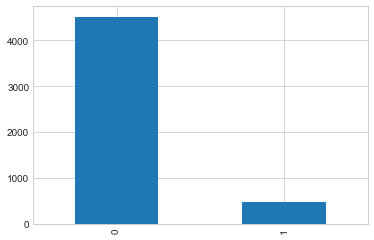

In [47]:
pd.value_counts(newdf["Personal Loan"]).plot(kind="bar")

In [48]:
# creating odd list of K for KNN
myList = list(range(1,20))

# subsetting just the odd ones
neighbors = list(filter(lambda x: x % 2 != 0, myList))

In [51]:
# empty list that will hold accuracy scores
ac_scores = []

# perform accuracy metrics for values from 1,3,5....19
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)
    # predict the response
    y_pred = knn.predict(X_test)
    # evaluate accuracy
    scores = accuracy_score(Y_test, y_pred)
    ac_scores.append(scores)

# changing to misclassification error
MSE = [1 - x for x in ac_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d" % optimal_k)

The optimal number of neighbors is 9


In [52]:
#Use k=3 as the final model for prediction
knn = KNeighborsClassifier(n_neighbors = 9)

# fitting the model
knn.fit(X_train, Y_train)

# predict the response
y_pred = knn.predict(X_test)

# calculate accuracy measures and confusion matrix
from sklearn import metrics

print(metrics.classification_report(Y_test, y_pred))
print(metrics.confusion_matrix(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95      1352
           1       0.45      0.16      0.23       148

    accuracy                           0.90      1500
   macro avg       0.68      0.57      0.59      1500
weighted avg       0.87      0.90      0.87      1500

[[1324   28]
 [ 125   23]]


In [53]:
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))
print(recall_score(Y_test, y_pred))

Accuracy: 0.898
0.1554054054054054


# Support Vector for Classification

In [54]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train, Y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(X_train, Y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, Y_test)))

C:\Users\VK186001\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy on training set: 1.00
Accuracy on test set: 0.90


Final Evaluation : SVM is best model which has best accuracy in training and test models